In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('cars_moldova_cat_num (2).csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,40,92,2011,4,195000,1800,2,1,7750,11,17727.272727
1,32,62,2014,11,135000,1500,0,0,8550,8,16875.000000
2,32,71,2012,11,110000,1500,0,0,6550,10,11000.000000
3,28,23,2006,11,200000,1600,3,0,4100,16,12500.000000
4,23,124,2000,5,300000,2200,0,0,3490,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...,...
32069,42,88,2016,10,88000,1800,4,1,11500,6,14666.666667
32070,19,53,2002,3,225000,1800,3,0,4400,20,11250.000000
32071,6,77,2015,11,89000,1500,0,0,7000,7,12714.285714
32072,22,10,2006,1,370000,2000,0,0,4000,16,23125.000000


### 4.1 Предсказание типа трансмиссии автомобилей с использованием модели логистической регрессии

In [3]:
# LinearRegression
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [4]:
# ElasticRegression
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty  + l2_term)

LogisticRegression

In [5]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty    = 0.0,
                 l2_penalty    = 0.0,
                 epochs        = 100, 
                 weights       = None, 
                 bias          = None, 
                 threshold     = 0.5,
                 batch_size    = 1000, 
                 n_batches     = None,
                 random_state  = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    #---------------------------------    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term   
    #---------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))     
    #---------------------------------
    def forward(self, X):     
        return self.sigmoid(np.dot(X, self.weights))   
    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1   
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return self.to_class(yhat)

    #---------------------------------
    def predict_prob(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat 
    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    #---------------------------------
    def plot_desicion_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =("#FF0000", '#0000FF'),
                               alpha=0.7, s = 150, poly = False, order = 2):
        plt.figure(figsize = figsize)
        cm_bright = ListedColormap(colors)
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);
        h =  (X[:, 0].max() - X[:, 0].min())/50
        x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max()+0.5
        y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max()+0.5    
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly:
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
        else:
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape) 
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
    #---------------------------------
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('False Positives:%.4f'%(fp/p), end = '\t')
        print('False Negatives:%.4f'%(fn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

In [6]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


In [7]:
def vis_weigths(weights, names):
    numbers = np.arange(0,len(weights))
    tick_labels = names
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels, rotation = 45 );

Рассмотрим результат с использованием L1- регуляризации

In [8]:
X,y = df.drop(columns = ['Transmission']).values, df['Transmission'].values
features_names = df.drop(columns = ['Transmission']).columns
X_train, y_train,  X_test, y_test = train_test_split(X, y,  test_size=0.3, )

#### MinMaxScaler

In [9]:
scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

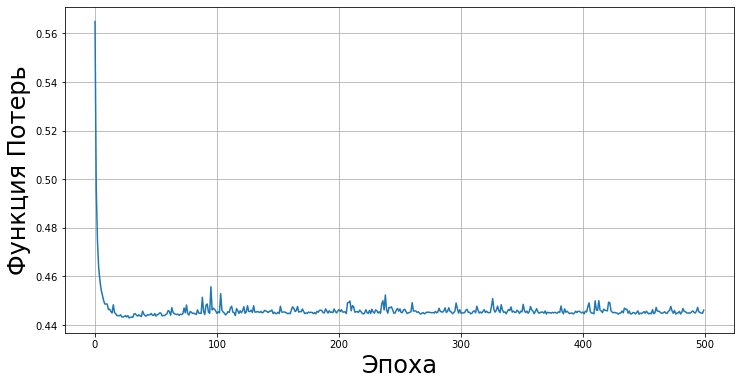

Test score: 0.7979, Train score: 0.7962
True Positives:0.9210	True Negatives:0.7434
False Positives:0.0790	False Negatives:0.2566
Accuracy:0.7979
Recall:0.6135	Precision:0.9210
f1 measure:0.7364


In [10]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50, l1_penalty=0.001, )

regr.fit(X_train, y_train)
regr.plot_cost()
print(f'Test score: {regr.score(X_test, y_test):.4f}, Train score: {regr.score(X_train, y_train):.4f}')
regr.classification_report(X_test, y_test)

#### StandardScaler

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

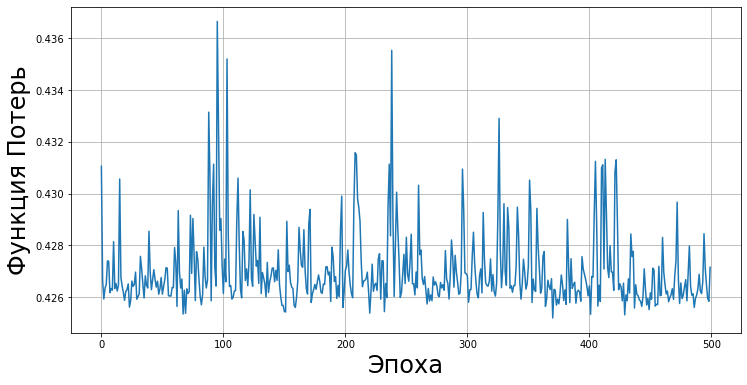

Test score: 0.8084, Train score: 0.8115
True Positives:0.8500	True Negatives:0.7825
False Positives:0.1500	False Negatives:0.2175
Accuracy:0.8084
Recall:0.7087	Precision:0.8500
f1 measure:0.7730


In [12]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50, l1_penalty=0.001, )
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regr.fit(X_train, y_train)
regr.plot_cost()
print(f'Test score: {regr.score(X_test, y_test):.4f}, Train score: {regr.score(X_train, y_train):.4f}')
regr.classification_report(X_test, y_test)

In [13]:
w, b = regr.get_w_and_b()
print(w,b)

[ 0.23953278 -0.201789    0.35564181  0.21937795  0.33148809  1.49807932
  0.37024593  1.96933786 -0.30278555 -0.14206239] -0.07547555925064066


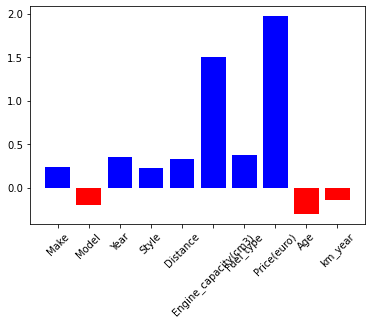

In [14]:
w, b = regr.get_w_and_b()
vis_weigths(w, features_names)

Из полученных данных видно, что наиболее значимыми признаками являются  Engine_capacity и Price

### Качество модели на тестовой и обучающей выборке

In [15]:
df1 = {'Name': ['Logistic', 'Logistic'], "Scaler": ["MinMaxScaler", "StandardScaler"], 'Score_train': [0.7962, 0.8115], 'Score_test': [0.7979, 0.8084], "f1 measure": [0.7364,0.7730]} 

In [16]:
df1 = pd.DataFrame(df1) 
df1

,Name,Scaler,Score_train,Score_test,f1 measure
0,Logistic,MinMaxScaler,0.7962,0.7979,0.7364
1,Logistic,StandardScaler,0.8115,0.8084,0.7730


При использовании StandardScaler наблюдается лучший результат

### 4.2  Оцените влияние разных типов предварительной обработки на результат

In [17]:
# Рассчитаем 0.75-квантиль и 0.25-квантиль
q75 = int(np.quantile(df['km_year'], 0.75))
q25 = int(np.quantile(df['km_year'], 0.25))

In [18]:
# Создадим новый столбец в который в будущем запишем категории пробега
df["km_year_new"] = df["km_year"]

In [19]:
# Сделаем соответствующую замену на небольшой, средний и большой пробеги
df["km_year_new"] = df["km_year_new"].apply(lambda x: (int(x) >= q75 and "Big") or (int(x) < q25 and "Small") or "Middle") 

In [20]:
df = df.drop("km_year", axis=1)

In [21]:
# Сделаем One Hot Encoding
df = pd.get_dummies(df, columns=['km_year_new'])
df.head(5)

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year_new_Big,km_year_new_Middle,km_year_new_Small
0,40,92,2011,4,195000,1800,2,1,7750,11,0,1,0
1,32,62,2014,11,135000,1500,0,0,8550,8,0,1,0
2,32,71,2012,11,110000,1500,0,0,6550,10,0,1,0
3,28,23,2006,11,200000,1600,3,0,4100,16,0,1,0
4,23,124,2000,5,300000,2200,0,0,3490,22,0,1,0


Удалим наименее значимые признаки и сравним score

<AxesSubplot:>

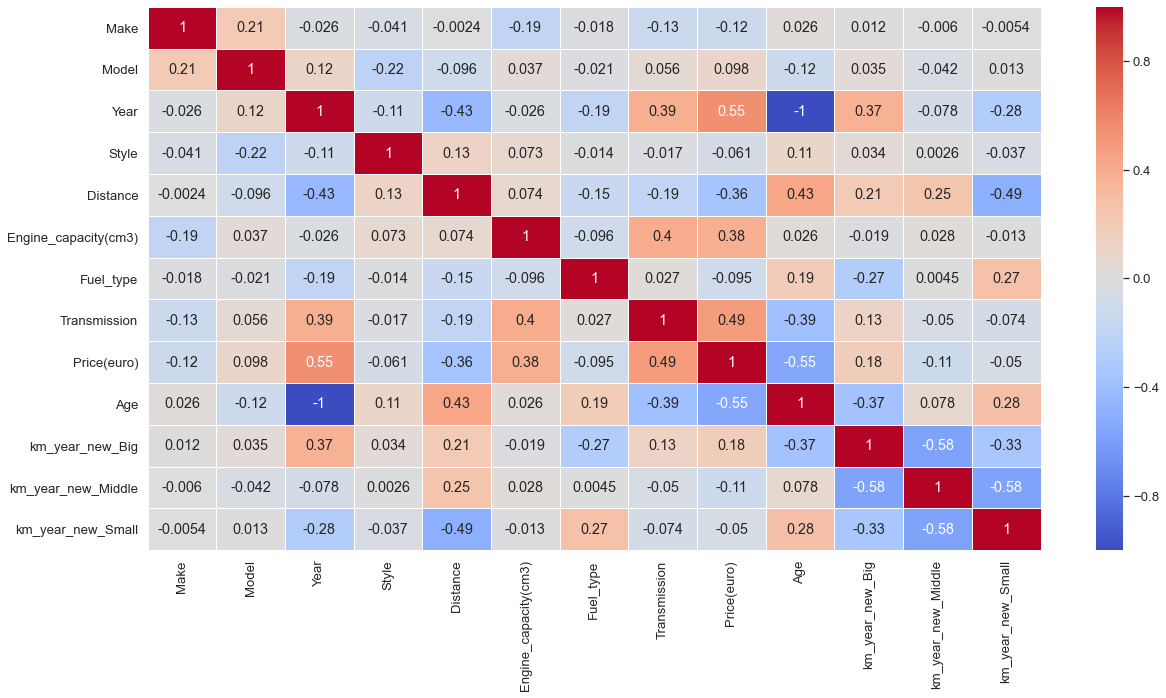

In [22]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.2)
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

Слабая корреляция между Transmission и Style

Признаки Year и Age имеют одинаковый смысл, поэтому удалим один из них.
Также Transmission сильно коррелирует с Year, посмотрим на score без этого признака

In [23]:
df = df.drop("Year", axis = 1)
df = df.drop("Style", axis=1)

Обучим модель без данных признаков

#### StandardScaler

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

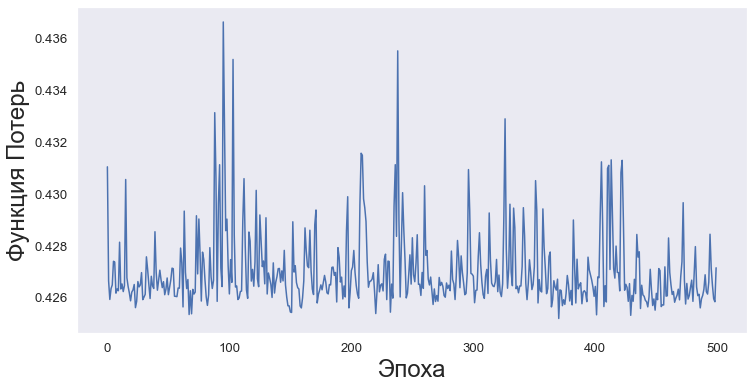

Test score: 0.8084, Train score: 0.8115
True Positives:0.8500	True Negatives:0.7825
False Positives:0.1500	False Negatives:0.2175
Accuracy:0.8084
Recall:0.7087	Precision:0.8500
f1 measure:0.7730


In [25]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50, l1_penalty=0.001, )

regr.fit(X_train, y_train)
regr.plot_cost()
print(f'Test score: {regr.score(X_test, y_test):.4f}, Train score: {regr.score(X_train, y_train):.4f}')
regr.classification_report(X_test, y_test)

#### MinMaxScaler

In [26]:
scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

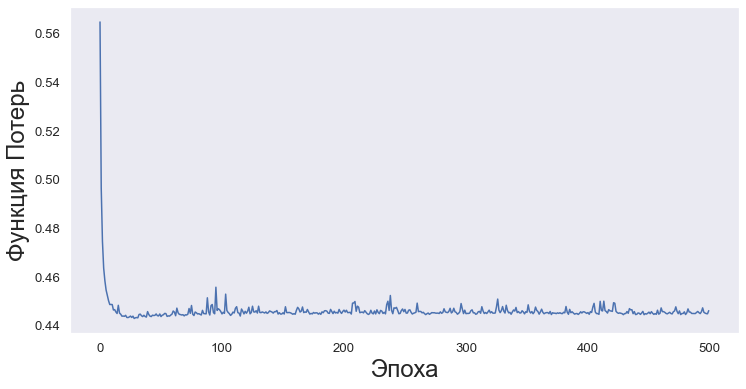

Test score: 0.7979, Train score: 0.7962
True Positives:0.9210	True Negatives:0.7434
False Positives:0.0790	False Negatives:0.2566
Accuracy:0.7979
Recall:0.6135	Precision:0.9210
f1 measure:0.7364


In [27]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50, l1_penalty=0.001, )

regr.fit(X_train, y_train)
regr.plot_cost()
print(f'Test score: {regr.score(X_test, y_test):.4f}, Train score: {regr.score(X_train, y_train):.4f}')
regr.classification_report(X_test, y_test)

### Качество модели после работы с признаками

In [28]:
df2 = {'Name': ['Logistic', 'Logistic', "Logistic", "Logistic"], 'Features': ["with all features","with all features", "without some features","without some features"], "Scaler": ["MinMaxScaler", "StandardScaler", "MinMaxScaler", "StandardScaler"], 'Score_train': [0.7914,0.8117, 0.8034, 0.8148], 'Score_test': [0.7894, 0.8039, 0.8035, 0.8068], "f1 measure": [0.7219, 0.7676, 0.7501, 0.7724]} 

In [29]:
df2 = pd.DataFrame(df2) 
df2

,Name,Features,Scaler,Score_train,Score_test,f1 measure
0,Logistic,with all features,MinMaxScaler,0.7914,0.7894,0.7219
1,Logistic,with all features,StandardScaler,0.8117,0.8039,0.7676
2,Logistic,without some features,MinMaxScaler,0.8034,0.8035,0.7501
3,Logistic,without some features,StandardScaler,0.8148,0.8068,0.7724


Качество модели после обработки данных стало лучше, так, например, F1 measure с 0.7676 увеличилась до 0.7724

### 4.3 Результат модели при использовании только числовых признаков

In [30]:
df.head(5)

,Make,Model,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year_new_Big,km_year_new_Middle,km_year_new_Small
0,40,92,195000,1800,2,1,7750,11,0,1,0
1,32,62,135000,1500,0,0,8550,8,0,1,0
2,32,71,110000,1500,0,0,6550,10,0,1,0
3,28,23,200000,1600,3,0,4100,16,0,1,0
4,23,124,300000,2200,0,0,3490,22,0,1,0


In [31]:
num_columns = ['Distance', 'Engine_capacity(cm3)', 'Price(euro)', "Age", "Transmission"]

In [32]:
from sklearn.model_selection import train_test_split
df_num = df[num_columns].copy()

df_num.info()
X_num,y_num = df_num.drop(columns = ['Transmission']).values,df_num['Transmission'].values
features_names = df_num.drop(columns = ['Transmission']).columns
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, test_size=0.3, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32074 entries, 0 to 32073
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Distance              32074 non-null  int64
 1   Engine_capacity(cm3)  32074 non-null  int64
 2   Price(euro)           32074 non-null  int64
 3   Age                   32074 non-null  int64
 4   Transmission          32074 non-null  int64
dtypes: int64(5)
memory usage: 1.2 MB


#### MinMaxScaler

In [33]:
scaler  = MinMaxScaler()
scaler.fit_transform(X_train_num)
X_train_num = scaler.transform(X_train_num) 
X_test_num  = scaler.transform(X_test_num) 

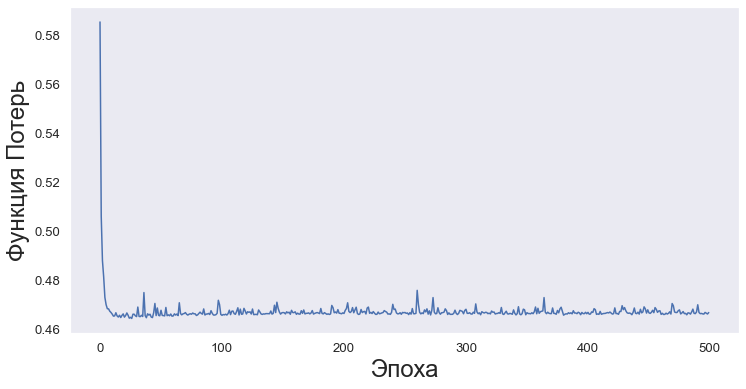

Test score: 0.8127, Train score: 0.8008
True Positives:0.8627	True Negatives:0.7837
False Positives:0.1373	False Negatives:0.2163
Accuracy:0.8127
Recall:0.6989	Precision:0.8627
f1 measure:0.7722


In [34]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50, l1_penalty=0.001, )

regr.fit(X_train_num, y_train_num)
regr.plot_cost()
print(f'Test score: {regr.score(X_test_num, y_test_num):.4f}, Train score: {regr.score(X_train_num, y_train_num):.4f}')
regr.classification_report(X_test_num, y_test_num)

#### StandardScaler

In [35]:
scaler = StandardScaler()
scaler.fit_transform(X_train_num)
X_train_num = scaler.transform(X_train_num) 
X_test_num  = scaler.transform(X_test_num)

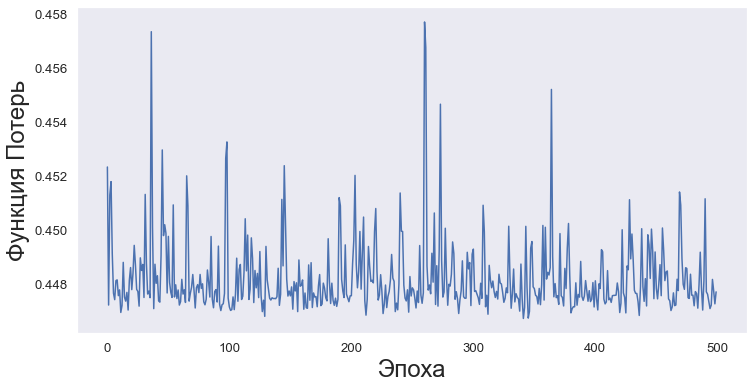

Test score: 0.8066, Train score: 0.7985
True Positives:0.8295	True Negatives:0.7916
False Positives:0.1705	False Negatives:0.2084
Accuracy:0.8066
Recall:0.7227	Precision:0.8295
f1 measure:0.7724


In [36]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50, l1_penalty=0.001, )

regr.fit(X_train_num, y_train_num)
regr.plot_cost()
print(f'Test score: {regr.score(X_test_num, y_test_num):.4f}, Train score: {regr.score(X_train_num, y_train_num):.4f}')
regr.classification_report(X_test_num, y_test_num)

In [37]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()

#### Результат для случая с числовыми признаками

In [38]:
df3 = {'Name': ['Logistic', 'Logistic'], "Scaler": ["MinMaxScaler","StandardScaler"], 'Score_train': [0.8008,  0.7985], 'Score_test': [0.8127, 0.8066], "f1 measure": [0.7722, 0.7724]} 

In [39]:
df3 = pd.DataFrame(df3) 
df3

,Name,Scaler,Score_train,Score_test,f1 measure
0,Logistic,MinMaxScaler,0.8008,0.8127,0.7722
1,Logistic,StandardScaler,0.7985,0.8066,0.7724


Для случая с числовыми признаками MinMaxScaler и StandardScaler дают приблизительно один результат

### Рассмотрим результат на численных и категориальных признаках

In [40]:
df.head(5)

,Make,Model,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year_new_Big,km_year_new_Middle,km_year_new_Small
0,40,92,195000,1800,2,1,7750,11,0,1,0
1,32,62,135000,1500,0,0,8550,8,0,1,0
2,32,71,110000,1500,0,0,6550,10,0,1,0
3,28,23,200000,1600,3,0,4100,16,0,1,0
4,23,124,300000,2200,0,0,3490,22,0,1,0


Сделаем One Hot Encoding для категориальных признаков 

In [41]:
df = pd.get_dummies(df, columns=['Make', "Model", "Fuel_type"])

In [42]:
X_dum,y_dum = df.drop(columns = ['Transmission']).values, df['Transmission'].values
features_names = df.drop(columns = ['Transmission']).columns
X_train, y_train,  X_test, y_test = train_test_split(X_dum, y_dum,  test_size=0.3, )

#### MinMaxScaler

In [43]:
scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test)

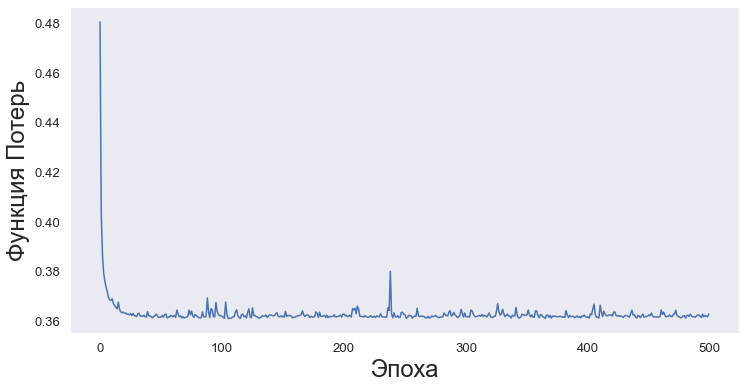

Test score: 0.8388, Train score: 0.8403
True Positives:0.9255	True Negatives:0.7919
False Positives:0.0745	False Negatives:0.2081
Accuracy:0.8388
Recall:0.7067	Precision:0.9255
f1 measure:0.8014


In [44]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50, l1_penalty=0.001, )

regr.fit(X_train, y_train)
regr.plot_cost()
print(f'Test score: {regr.score(X_test, y_test):.4f}, Train score: {regr.score(X_train, y_train):.4f}')
regr.classification_report(X_test, y_test)

#### StandardScaler

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

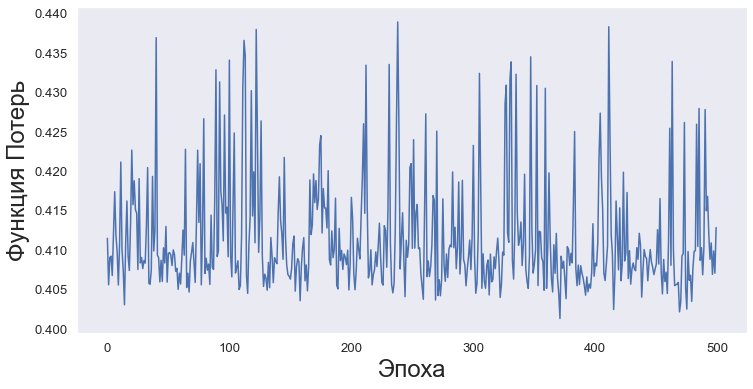

Test score: 0.8281, Train score: 0.8362
True Positives:0.8410	True Negatives:0.8187
False Positives:0.1590	False Negatives:0.1813
Accuracy:0.8281
Recall:0.7726	Precision:0.8410
f1 measure:0.8054


In [46]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50, l1_penalty=0.001, )

regr.fit(X_train, y_train)
regr.plot_cost()
print(f'Test score: {regr.score(X_test, y_test):.4f}, Train score: {regr.score(X_train, y_train):.4f}')
regr.classification_report(X_test, y_test)

### Сравнение результатов для случая обучения модели только на числовых признаках и с учетом всех признаков 

In [47]:
df4 = {'Name': ['Logistic', 'Logistic', 'Logistic', 'Logistic'], "Features": ["with all features", "with all features", "with numeric features", "with numeric features"], "Scaler": ["MinMaxScaler","StandardScaler", "MinMaxScaler","StandardScaler"], 'Score_train': [0.8364, 0.8283, 0.8008,  0.7985], 'Score_test': [0.8127, 0.8066, 0.8388,  0.8281], "f1 measure": [0.7722, 0.7724, 0.8014, 0.8054]} 

In [48]:
df4 = pd.DataFrame(df4) 
df4

,Name,Features,Scaler,Score_train,Score_test,f1 measure
0,Logistic,with all features,MinMaxScaler,0.8364,0.8127,0.7722
1,Logistic,with all features,StandardScaler,0.8283,0.8066,0.7724
2,Logistic,with numeric features,MinMaxScaler,0.8008,0.8388,0.8014
3,Logistic,with numeric features,StandardScaler,0.7985,0.8281,0.8054


Таким образом, качество модели при использовании всех признаков лучше, чем при использовании только числовых признаков, так для стандартизации MinMaxScaler score увеличился с 0.8127 до 0.8388

### 4.4 Наиболее значимые признаки для случая с one hot encoding

In [49]:
w_new = pd.Series(w)
res = w_new.nlargest(10)
print(res)
features_names_ = features_names[res.index]
features_names_

7    1.969338
5    1.498079
6    0.370246
2    0.355642
4    0.331488
0    0.239533
3    0.219378
9   -0.142062
1   -0.201789
8   -0.302786
dtype: float64


Index(['Make_0', 'km_year_new_Middle', 'km_year_new_Small', 'Price(euro)',
       'km_year_new_Big', 'Distance', 'Age', 'Make_2', 'Engine_capacity(cm3)',
       'Make_1'],
      dtype='object')

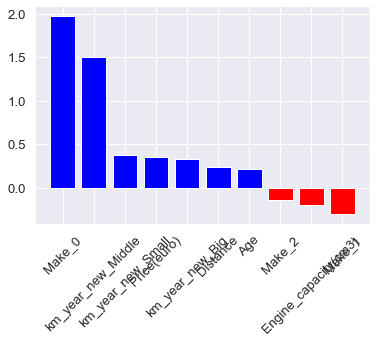

In [50]:
vis_weigths(res, features_names_)

Из полученных данных видно, что наиболее значимыми признаками являются Make и km_year